# Example: NL Assortment Optimization (Unconstrained)

This notebook demonstrates how to test an algorithm for the hard instances of the ** Nested Logit (NL)** choice model under the unconstrained setting.

It shows how to:
1. Load the instance
2. Run a method for the instances
3. Interpret the results provided by the algorithms.

## 1. Import Required Modules

In [4]:
import sys
import os
import json

import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

notebook_path = os.getcwd() 
project_root = os.path.dirname(notebook_path)  # get the project root directory
sys.path.append(project_root)

from generator.nl_data_generator import *
from generator.utils import *
from generator.constraint import *
from models.nl_functions import *
from method.nl_method import *
from plot import *

print("✅ Modules imported successfully.")

✅ Modules imported successfully.


### 2. Unconstrained Assortment Optimization
In this section, we solve the assortment optimization problem without any additional constraints.

#### 2.1 Load Data
- We provide two json files in the hard_data folder based on different vi0 distributions
- The number of nests $m \in \{5, 10, 15\}$
- The number of products per nest $n \in \{25, 50, 75\}$
- The vi0 distributions include:
   - **uniform01**: vi0 ~ Uniform(0, 1) - Low outside-nest utility
   - **uniform34**: vi0 ~ Uniform(3, 4) - High outside-nest utility

In [5]:
hard_instance_dir = project_root + "/hard_data/"
vi0_method = '01'  # Options: '01', '34'
input_json_path = hard_instance_dir + "nl_unconstrained_" + vi0_method + "_data.json"
instances = load_NL_instances(input_json_path)
print(f"✅ Loaded {len(instances)} instances")

✅ Loaded 139 instances


DATASET STRUCTURE SUMMARY


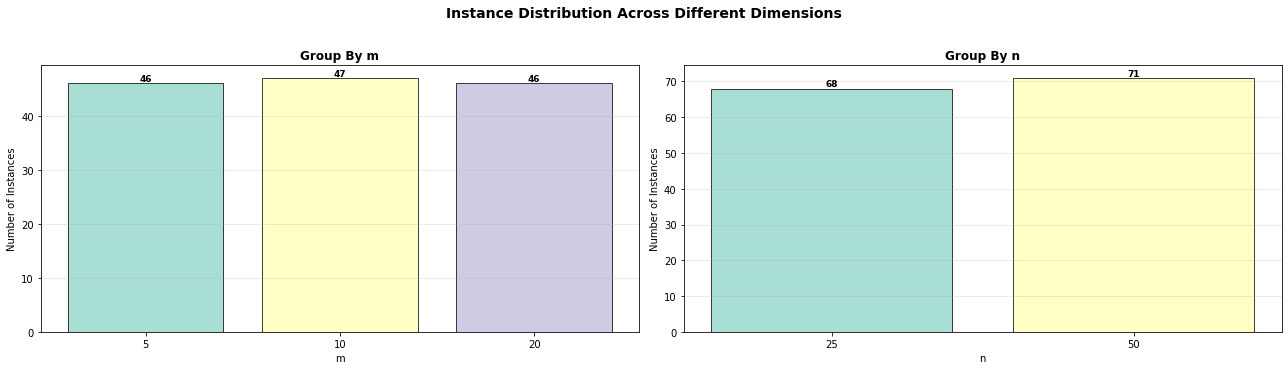

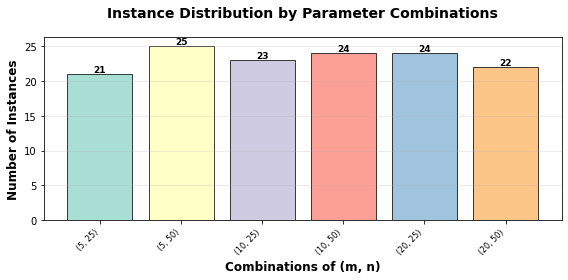

In [6]:
group_cols=['m', 'n']
plot_instance_summary(instances,group_cols)

### 2.2 Demonstrate the Structure of the Instance

No handles with labels found to put in legend.


INSTANCE OVERVIEW
Number of customer segments (m): 5
Number of products (n): 25
Random seed: 46
Capacity rate: 1
Maximum revenue (optimal): 6.2455

DATA COMPONENTS - DIMENSIONS
1. Utility Matrix (v): shape (5, 25), range: [0.0811, 11.5391]
2. Product Prices (price): shape (5, 25),range: [0.0004, 11.2488]
3. Dissimilarity Parameter (gamma): shape (5,),range: [2.0772, 2.9340]
4. No-Purchase Utility (v0): 10.0000
5. Within-Nest No-Purchase Utility (vi0): shape: (5,), range: [0.0772, 0.9340]

DATA VISUALIZATION


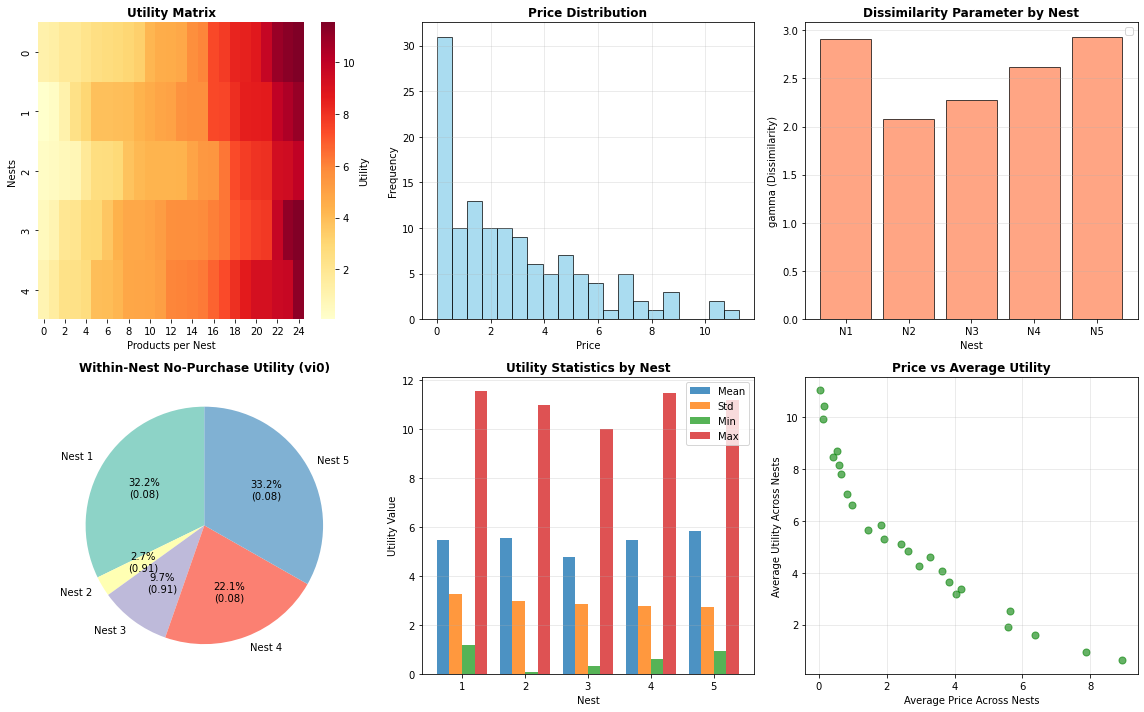

In [7]:
data = instances[0] # select an instance to explore
model_type = "NL"
explore_instance(data, model_type)

### 2.3 Run Algorithm on All Instances

In [8]:
# Initialize data paths and result storage
hard_instance_dir = project_root + "/hard_data/"
vi0_method_list = ['01', '34']  # Two vi0 distribution methods to test
results = []

# Loop through each vi0 method
for vi0_method in vi0_method_list:
    # Load instances for the current vi0 method
    input_json_path = hard_instance_dir + "nl_unconstrained_" + vi0_method + "_data.json"
    instances = load_NL_instances(input_json_path)
    
    print(f"\nProcessing {vi0_method}...")
    
    # Process each instance
    for idx, data in enumerate(instances):
        # Get the revenue function for this instance
        revenue_fn = get_revenue_function_nl(data)
        
        # Run the revenue-ordered heuristic algorithm for NL
        # This algorithm finds the optimal assortment by selecting the k_i highest-revenue products in each nest i
        assortment = revenue_order_nl(data.m, data.n, data.v, data.price, 
                                      data.v0, data.vi0, data.gamma)
        
        # Calculate the revenue achieved by the heuristic
        revenue = revenue_fn(assortment)[0]
        
        # Get the optimal revenue (from exact solution)
        opt_rev = data.max_rev
        
        # Calculate the optimality gap (in percentage)
        gap_method = (opt_rev - revenue) / opt_rev * 100
        
        # Store results for this instance
        result_dict = {
            'm': data.m,                    # Number of nests
            'n': data.n,                    # Number of products per nest
            'vi0_method': vi0_method,       # vi0 distribution method
            'cap_rate': data.cap_rate,      # Capacity rate
            'seed': data.seed,              # Random seed for reproducibility
            'max_rev': opt_rev,             # Optimal revenue
            'gap_method': gap_method        # Optimality gap (%)
        }
        
        results.append(result_dict)

print(f"\n✅ Completed testing on {len(results)} instances.")


Processing 01...
Set parameter LicenseID to value 2639519

Processing 34...

✅ Completed testing on 282 instances.


### 2.4 Save Detailed Statistics to Excel

In [9]:
# Convert results to DataFrame for easier analysis
df_results = pd.DataFrame(results)

# Create a combined column for (m, n) pairs for easier grouping
df_results['m_n'] = df_results['m'].astype(str) + '_' + df_results['n'].astype(str)

# Display basic statistics
print(f"Total instances tested: {len(df_results)}")
print(f"vi0 methods: {df_results['vi0_method'].unique().tolist()}")
print(f"(m, n) combinations: {sorted(df_results['m_n'].unique().tolist())}")

output_dir = project_root + "/results/"
file_name="nl_summary_statistics.xlsx"
method_col="vi0_method"
export_summary_statistics(df_results,output_dir,file_name,method_col)

Total instances tested: 282
vi0 methods: ['01', '34']
(m, n) combinations: ['10_25', '10_50', '20_25', '20_50', '5_25', '5_50']


### 2.5 Visualize Algorithm Performance

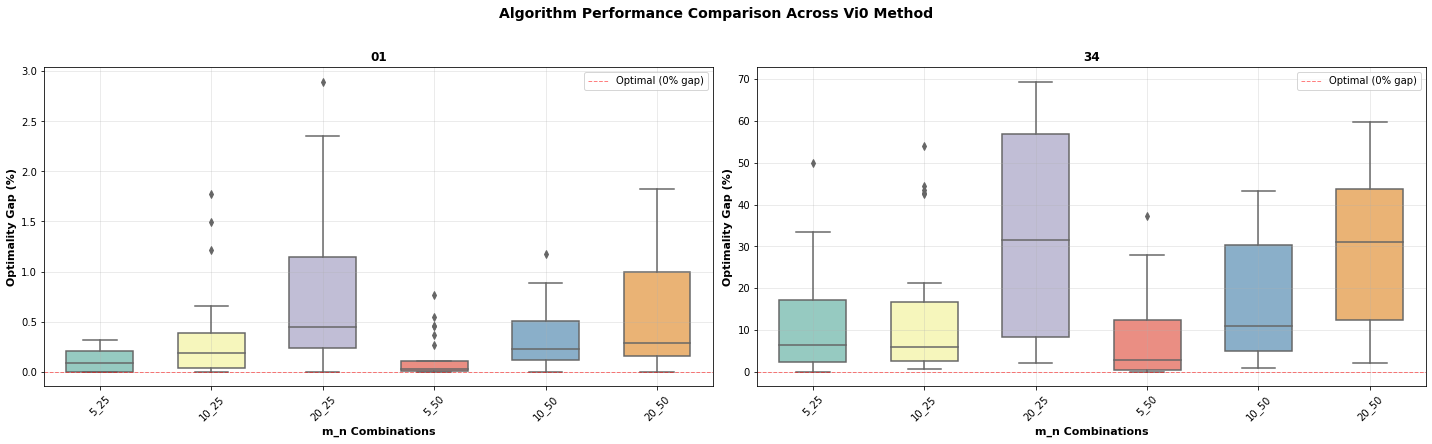


01 Performance Summary:
         mean     std  min     max
m_n                               
10_25  0.3518  0.4979  0.0  1.7774
10_50  0.3128  0.2906  0.0  1.1779
20_25  0.8388  0.8243  0.0  2.8951
20_50  0.5373  0.5368  0.0  1.8213
5_25   0.1127  0.1109 -0.0  0.3162
5_50   0.1378  0.2124 -0.0  0.7701

34 Performance Summary:
          mean      std     min      max
m_n                                     
10_25  14.1423  17.1792  0.5608  53.9696
10_50  16.6148  14.5564  0.9693  43.1909
20_25  33.8940  23.7289  2.1951  69.3915
20_50  28.3669  18.9356  2.0213  59.6632
5_25   12.1304  13.2094 -0.0000  49.8440
5_50    8.0999  10.5759  0.0179  37.3505


In [10]:
method_col = 'vi0_method'
group_col = 'm_n'
plot_comparison_boxplots(df_results,method_col,group_col)